# Banking and Poverty
---
The below script explores the relationship between states with high poverty rates and bank counts per state.

In this script, we retrieved and plotted data from the 2013 US Census and Google Places API to show the relationship between various socioeconomic parameters and bank count across 700 randomly selected zip codes. We used Pandas, Numpy, Matplotlib, Requests, Census API, and Google API to accomplish our task.

In [1]:
# Dependencies
from census import Census
from api_keys import (census_key, g_key)
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from scipy.stats import linregress
from matplotlib import pyplot as plt


# Census API Key
c = Census(census_key, year=2013)

## Data Retrieval

In [2]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
census_data = c.acs5.get(("B01003_001E", "B17001_002E","B11001_001E","B19013_001E"), {'for': 'zip code tabulation area:*'})


# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B17001_002E": "Poverty Count",
                                      "B11001_001E": "Number of Households",
                                      "B19013_001E": "Household Income",
                                      "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Poverty Rate", "Number of Households","Household Income"]]

# Visualize
print(len(census_pd))
census_pd.head()

33120


Zipcode  Population  Poverty Rate  Number of Households  Household Income
0   01832     22121.0     10.903666                8528.0           57833.0
1   01833      8295.0      2.302592                2885.0          107775.0
2   01834      6675.0      2.187266                2334.0           97463.0
3   01835     13527.0      8.523693                5129.0           72228.0
4   01840      4547.0     39.542556                2106.0           18261.0

In [3]:
EVStation = pd.read_csv("EVstation_data.csv")
EVStation.head()

State         city Zipcode   latitude   longitude
0    CA   Sun Valley   91352  34.248319 -118.387971
1    CA  Los Angeles   90024  34.052542 -118.448504
2    CA     Rosemead   91770  34.050745 -118.081014
3    CA  Los Angeles   90015  34.040539 -118.271387
4    CA  Los Angeles   90012  34.059133 -118.248589

## Combine Data

In [4]:
# Import the zip bank data. Use dtype="object" to ensure all data is read in accurately.
census_data_original = pd.read_csv(
    "merged.csv", dtype="object", encoding="utf-8")

# Visualize
census_data_original.head()

Unnamed: 0 State         city Zipcode          latitude           longitude  \
0          0    CA   Sun Valley   91352  34.2483191527193  -118.3879713743439   
1          6    CA  Los Angeles   90024         34.052542         -118.448504   
2       1352    CA     Rosemead   91770         34.050745         -118.081014   
3       1367    CA   Long Beach   90803         33.759802         -118.096665   
4       1591    CA   Sacramento   95814         38.576769         -121.495022   

  counts  
0      6  
1   1346  
2     15  
3    224  
4    258

In [5]:
# Merge the two data sets along zip code
census_data_complete = pd.merge(
    census_data_original, census_pd, how="left", on=["Zipcode", "Zipcode"])

# Remove rows missing data
census_data_complete = (census_data_complete[census_data_complete["Household Income"]>0]).dropna()

# Visualize
census_data_complete.head()

Unnamed: 0 State         city Zipcode          latitude           longitude  \
0          0    CA   Sun Valley   91352  34.2483191527193  -118.3879713743439   
1          6    CA  Los Angeles   90024         34.052542         -118.448504   
2       1352    CA     Rosemead   91770         34.050745         -118.081014   
3       1367    CA   Long Beach   90803         33.759802         -118.096665   
4       1591    CA   Sacramento   95814         38.576769         -121.495022   

  counts  Population  Poverty Rate  Number of Households  Household Income  
0      6     46334.0     19.072387               12323.0           48844.0  
1   1346     50964.0     24.784161               17423.0           54373.0  
2     15     62489.0     17.889549               16691.0           47373.0  
3    224     30563.0      8.202729               16754.0           72653.0  
4    258      9802.0     22.444399                5036.0           34085.0

## Heatmap of Poverty Rate

In [6]:
# Configure gmaps with API key
gmaps.configure(api_key=g_key)

In [7]:
# Store 'Lat' and 'Lng' into  locations 
locations = census_data_complete[["latitude", "longitude"]].astype(float)

# Convert Poverty Rate to float and store
# HINT: be sure to handle NaN values
census_data_complete = census_data_complete.dropna()
poverty_rate = census_data_complete["Poverty Rate"].astype(float)
household_income = census_data_complete["Household Income"].astype(int)

In [8]:
fig = gmaps.figure()

income_layer = gmaps.heatmap_layer(locations, weights=household_income/10000, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(income_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [9]:
# # Plot 20K+ EV stations
# locations=EVStation[['latitude','longitude']]

# # fig =gmaps.figure()

# station_layer = gmaps.symbol_layer(
#     locations, fill_color='rgba(0, 150, 0, 0.4)',
#     stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
# #     info_box_content=[f"Bank amount: {bank}" for bank in bank_rate]
# )


# fig.add_layer(station_layer)

# fig

In [10]:
# Create a poverty Heatmap layer
locations = census_data_complete[["latitude", "longitude"]].astype(float)
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=poverty_rate, 
                                 dissipating=False, max_intensity=400,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [11]:
# Convert bank rate to list
bank_rate = census_data_complete["counts"].tolist()

In [12]:
# Create bank symbol layer
bank_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    info_box_content=[f"Bank amount: {bank}" for bank in bank_rate]
)


fig = gmaps.figure()
fig.add_layer(bank_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [13]:
# Create a combined map
fig = gmaps.figure()

fig.add_layer(heat_layer)
fig.add_layer(bank_layer)

fig

Figure(layout=FigureLayout(height='420px'))

## Statistical Analysis

#### Summary Statistics

In [14]:
# Mean, median, mode for Poverty Rate
poverty_mean = round(census_data_complete['Poverty Rate'].astype('float').mean(), 2)
poverty_median = round(census_data_complete['Poverty Rate'].astype('float').median(), 2)
poverty_mode = round(census_data_complete['Poverty Rate'].astype('float').mode(), 2)

print(f"Poverty Rate Mean: {poverty_mean}")
print(f"Poverty Rate Median {poverty_median}")
print(f"Poverty Rate mode {poverty_mode}")

Poverty Rate Mean: 14.2
Poverty Rate Median 12.9
Poverty Rate mode 0    0.0
dtype: float64


In [15]:
# Mean, median, mode for Bank Count
bank_mean = round(census_data_complete['counts'].astype('float').mean(), 2)
bank_median = round(census_data_complete['counts'].astype('float').median(), 2)
bank_mode = round(census_data_complete['counts'].astype('float').mode(), 2)

print(f"Bank Count Mean: {bank_mean}")
print(f"Bank Count Median {bank_median}")
print(f"Bank Count mode {bank_mode}")

Bank Count Mean: 13.41
Bank Count Median 3.0
Bank Count mode 0    1.0
dtype: float64


In [16]:
# Mean, median, mode for Population
population_mean = round(census_data_complete['Population'].astype('float').mean(), 2)
population_median = round(census_data_complete['Population'].astype('float').median(), 2)
population_mode = round(census_data_complete['Population'].astype('float').mode(), 2)

print(f"Population Mean: {population_mean}")
print(f"Population Median {population_median}")
print(f"Population mode {population_mode}")

Population Mean: 21317.61
Population Median 16930.5
Population mode 0      781.0
1    23478.0
2    27625.0
3    29400.0
dtype: float64


#### Linear Regression

R squared: 2.6213348491923447e-05
std dev: 0.15986257328877568


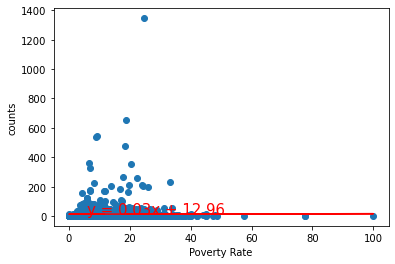

In [17]:
## Convert to floats and store Poverty Rate and Bank Count as x and y values
x_values = census_data_complete['Poverty Rate'].astype('float')
y_values = census_data_complete['counts'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Poverty Rate')
plt.ylabel('counts')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"std dev: {stderr}")
# Show plot
plt.show()

R squared: 0.006102799434143269
std dev: 0.026426559123344892


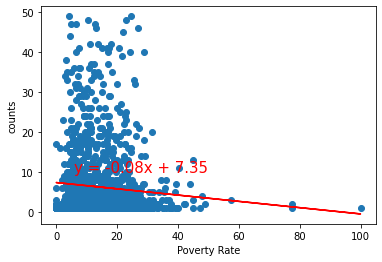

In [18]:
census_data_complete['counts'] = census_data_complete['counts'].astype('float')
smallercounty = census_data_complete.loc[census_data_complete['counts']<50]

## Convert to floats and store Poverty Rate and Bank Count as x and y values
x_values = smallercounty['Poverty Rate'].astype('float')
y_values = smallercounty['counts'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Poverty Rate')
plt.ylabel('counts')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"std dev: {stderr}")
# Show plot
plt.show()

R squared: 0.004845489703172146
std dev: 5.5921526961077776e-05


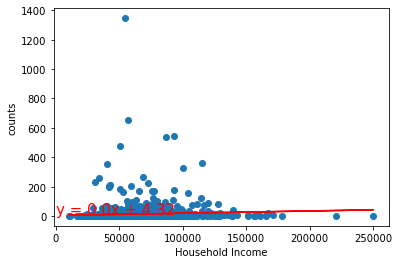

In [19]:
## Convert to floats and store Poverty Rate and Bank Count as x and y values
x_values = census_data_complete['Household Income'].astype('float')
y_values = census_data_complete['counts'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Household Income')
plt.ylabel('counts')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"std dev: {stderr}")
# Show plot
plt.show()

R squared: 0.025223423396642068
std dev: 9.264498143236238e-06


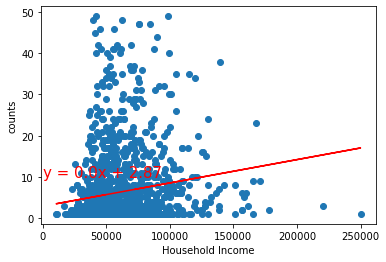

In [20]:
census_data_complete['counts'] = census_data_complete['counts'].astype('float')
smallercounty = census_data_complete.loc[census_data_complete['counts']<50]

## Convert to floats and store Poverty Rate and Bank Count as x and y values
x_values = smallercounty['Household Income'].astype('float')
y_values = smallercounty['counts'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Household Income')
plt.ylabel('counts')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"std dev: {stderr}")
# Show plot
plt.show()

### Analysis
* There is a very weak correlation between poverty rates and bank counts. Keep in mind that linear regression will not consider other factors such as population or size of the city.

R squared: 0.036694862915901925
std dev: 1.359801569856148e-05


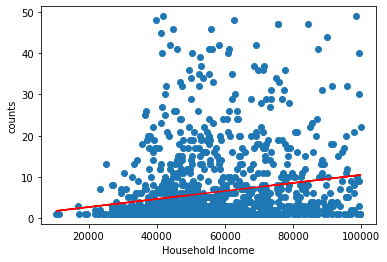

In [21]:
# census_data_complete['counts'] = census_data_complete['counts'].astype('float')
census_data_complete['Household Income'] = census_data_complete['Household Income'].astype('float')
smallerincome = smallercounty.loc[(smallercounty['Household Income']<100000)]

## Convert to floats and store Poverty Rate and Bank Count as x and y values
x_values = smallerincome ['Household Income'].astype('float')
y_values = smallerincome ['counts'].astype('float')

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")

# Label plot
plt.xlabel('Household Income')
plt.ylabel('counts')

# Print r square value
print(f"R squared: {rvalue**2}")
print(f"std dev: {stderr}")
# Show plot
plt.show()